SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-3-13f9f3a20dbb>, line 84)

In [ ]:
import tensorflow as tf
# Check if a GPU is available.
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

GPU is available


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Wed Dec 25 11:03:59 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P8               9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import os
#import warnings
#warnings.filterwarnings("ignore")

# Memory cleanup and optimization
import gc



# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load dataset
#print("\n=== Loading Dataset ===")
#!gdown "https://drive.google.com/uc?id=10E9RV2p0XREskcaDeJMvQ430tgGDgq1Z"
#data = pd.read_csv('labeled_sample_data.csv')

# 3. Load and prepare data
#url for 6000= https://drive.google.com/file/d/1PS8MS_0DVu6Qj3eozRr8Hkmj-3KC4T23/view?usp=drive_link
!gdown "https://drive.google.com/uc?id=1PS8MS_0DVu6Qj3eozRr8Hkmj-3KC4T23"
print("\n=== Loading Dataset ===")
data = pd.read_csv('6000labeled_sample_data_all.csv', encoding='ISO-8859-1')
print(f"Dataset size: {len(data)} rows")

# Check for NaN values
print("\nChecking for NaN values:")
print(data.isnull().sum())

# Remove rows with NaN values
data = data.dropna(subset=['cleaned_text', 'cleaned_body', 'label_agreement'])
print(f"\nDataset size after removing NaN: {len(data)} rows")

# Prepare data
posts = data['cleaned_text'].tolist()
comments = data['cleaned_body'].tolist()
labels = data['label_agreement'].map({-1: 0, 0: 1, 1: 2}).tolist()

# Print label distribution
label_dist = pd.Series(labels).value_counts()
print("\nLabel distribution:")
print(label_dist)

# Initialize tokenizer
print("\n=== Initializing Tokenizer ===")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Analyze token lengths
print("\n=== Analyzing Token Lengths ===")
post_lengths = []
comment_lengths = []
combined_lengths = []

# Sample 5 random pairs for detailed analysis
print("\nDetailed analysis of 5 random samples:")
np.random.seed(42)  # for reproducibility
for i in np.random.randint(0, len(posts), 5):
    # Tokenize post
    post_tokens = tokenizer.encode(posts[i], add_special_tokens=True)
    post_lengths.append(len(post_tokens))

    # Tokenize comment
    comment_tokens = tokenizer.encode(comments[i], add_special_tokens=True)
    comment_lengths.append(len(comment_tokens))

    # Tokenize combined
    combined = f"{posts[i]} [SEP] {comments[i]}"
    combined_tokens = tokenizer.encode(combined, add_special_tokens=True)
    combined_lengths.append(len(combined_tokens))

    print(f"\nSample {i}:")
    print(f"Post length: {len(post_tokens)} tokens")
    print(f"Comment length: {len(comment_tokens)} tokens")
    print(f"Combined length: {len(combined_tokens)} tokens")
    print(f"Label: {labels[i]}")

print("\nToken length statistics:")
print(f"Average post length: {np.mean(post_lengths):.1f} tokens")
print(f"Average comment length: {np.mean(comment_lengths):.1f} tokens")
print(f"Average combined length: {np.mean(combined_lengths):.1f} tokens")




Using device: cuda
Downloading...
From: https://drive.google.com/uc?id=1PS8MS_0DVu6Qj3eozRr8Hkmj-3KC4T23
To: /content/6000labeled_sample_data_all.csv
100% 65.2M/65.2M [00:00<00:00, 168MB/s]

=== Loading Dataset ===
Dataset size: 6000 rows

Checking for NaN values:
level_0                       0
index                         0
post_id                       0
link_id                       0
subreddit                     0
parent_id                     0
redditor_id                   0
created_at                    0
body                          0
score                         0
edited                        0
parent_id_clean               0
has_delta                     0
title                         0
text                          0
permalink                     0
post_id_parent                1
redditor_id_parent            1
body_clean                    0
knowledge_mean                0
knowledge_max                 0
knowledge_min                 0
knowledge_std                 0

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1687 > 512). Running this sequence through the model will result in indexing errors



=== Analyzing Token Lengths ===

Detailed analysis of 5 random samples:

Sample 860:
Post length: 1687 tokens
Comment length: 52 tokens
Combined length: 1738 tokens
Label: 0

Sample 5390:
Post length: 292 tokens
Comment length: 49 tokens
Combined length: 340 tokens
Label: 0

Sample 5226:
Post length: 192 tokens
Comment length: 24 tokens
Combined length: 215 tokens
Label: 1

Sample 5191:
Post length: 137 tokens
Comment length: 68 tokens
Combined length: 204 tokens
Label: 0

Sample 3772:
Post length: 1687 tokens
Comment length: 285 tokens
Combined length: 1971 tokens
Label: 0

Token length statistics:
Average post length: 799.0 tokens
Average comment length: 95.6 tokens
Average combined length: 893.6 tokens


In [ ]:
# Smart tokenization function
def smart_truncate_and_tokenize(posts, comments, max_length=512):
    """
    Smartly truncates and tokenizes posts and comments with more tokens allocated to posts

    Args:
        posts: List of post texts
        comments: List of comment texts
        max_length: Maximum sequence length

    Returns:
        tokens: Dictionary containing input_ids, attention_mask, and other tokenizer outputs
    """
    # Allocate more tokens to posts (70-30 split)
    post_max_length = int(max_length * 0.7)
    comment_max_length = max_length - post_max_length - 3  # Account for special tokens

    truncated_pairs = []
    for post, comment in zip(posts, comments):
        # Tokenize post and comment separately
        post_tokens = tokenizer.encode(
            post,
            add_special_tokens=False,
            truncation=True,
            max_length=post_max_length
        )

        comment_tokens = tokenizer.encode(
            comment,
            add_special_tokens=False,
            truncation=True,
            max_length=comment_max_length
        )

        # Combine with special tokens
        combined_tokens = [tokenizer.cls_token_id] + post_tokens + [tokenizer.sep_token_id] + comment_tokens + [tokenizer.sep_token_id]
        truncated_pairs.append(combined_tokens)

    # Pad sequences
    padded_pairs = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(x) for x in truncated_pairs],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )

    # Create attention masks
    attention_masks = (padded_pairs != tokenizer.pad_token_id).long()

    return {
        'input_ids': padded_pairs,
        'attention_mask': attention_masks
    }


In [ ]:
# just for test how it works and for debugging


logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

def smart_truncate_and_tokenize_with_logging(posts, comments, max_length=512):
    post_max_length = int(max_length * 0.7)
    comment_max_length = max_length - post_max_length - 3  # Special tokens
    truncated_pairs = []

    for i, (post, comment) in enumerate(zip(posts, comments)):
        post_tokens = tokenizer.encode(post, add_special_tokens=False, truncation=True, max_length=post_max_length)
        comment_tokens = tokenizer.encode(comment, add_special_tokens=False, truncation=True, max_length=comment_max_length)
        combined_tokens = [tokenizer.cls_token_id] + post_tokens + [tokenizer.sep_token_id] + comment_tokens + [tokenizer.sep_token_id]
        truncated_pairs.append(combined_tokens)

        logger.info(f"Sample {i}: Post Tokens = {len(post_tokens)}, Comment Tokens = {len(comment_tokens)}, Combined = {len(combined_tokens)}")

    padded_pairs = torch.nn.utils.rnn.pad_sequence(
        [torch.tensor(x) for x in truncated_pairs],
        batch_first=True,
        padding_value=tokenizer.pad_token_id
    )

    attention_masks = (padded_pairs != tokenizer.pad_token_id).long()

    return {
        'input_ids': padded_pairs,
        'attention_mask': attention_masks
    }


In [ ]:
# testing the dataset with the Example data as below:

# Example data
postsamp = [
    "This is a very long example post that exceeds the token limit.",
    "Another example of a post with more content.",
    "the this post can be to long and stupid, but i like to add this scientific things here to mention that some idea can be practical however silly and opinion changing."
]
commentsamp = [
    "This is a short comment. for these exceed tokens we need to add some steps.",
    "Another short commentshows that better content is the long ones.",
    "I do not belive it at all becuase when i was young I though similar, but know i beleve stupid is stupid."
]
labelsamp = [1, 2, 0]  # Ensure at least 2 samples per class

# Test the function smart_truncate_and_tokenize_with_logging
tokens = smart_truncate_and_tokenize(postsamp, commentsamp)

# Inspect tokenized results 1
print("Input IDs:", tokens['input_ids'])
print("Attention Masks:", tokens['attention_mask'])
print("---------------------------------------------------------------")
# print both sentences reuslt of tokenizing for 3

print("Input IDs:", tokens['input_ids'][0].tolist(), tokens['input_ids'][1].tolist(), tokens['input_ids'][2].tolist())
print("Attention Masks:", tokens['attention_mask'][0].tolist(), tokens['attention_mask'][1].tolist(), tokens['attention_mask'][2].tolist())
print("---------------------------------------------------------------")
# Decode a sample
decoded_text_1 = tokenizer.decode(tokens['input_ids'][0].tolist(), skip_special_tokens=False)
print("Decoded Tokens (Sample 1):", decoded_text_1)
print("******************************************************")

decoded_text_2= tokenizer.decode(tokens['input_ids'][1].tolist(), skip_special_tokens=False)
print("Decoded Tokens (Sample 2):", decoded_text_2)
print("******************************************************")
decoded_text_3= tokenizer.decode(tokens['input_ids'][2].tolist(), skip_special_tokens=False)
print("Decoded Tokens (Sample 3):", decoded_text_3)
# Test the function smart_truncate_and_tokenize
#tokens = smart_truncate_and_tokenize(postsamp, comments)

# Inspect tokenized results
#print("Input IDs:", tokens['input_ids'])
#print("Attention Masks:", tokens['attention_mask'])

# Decode a sample
#decoded_text = tokenizer.decode(tokens['input_ids'][0].tolist(), skip_special_tokens=False)
#print("Decoded Tokens (Sample 1):", decoded_text)

Input IDs: tensor([[  101,  2023,  2003,  1037,  2200,  2146,  2742,  2695,  2008, 23651,
          1996, 19204,  5787,  1012,   102,  2023,  2003,  1037,  2460,  7615,
          1012,  2005,  2122, 13467, 19204,  2015,  2057,  2342,  2000,  5587,
          2070,  4084,  1012,   102,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0],
        [  101,  2178,  2742,  1997,  1037,  2695,  2007,  2062,  4180,  1012,
           102,  2178,  2460,  7928, 14406,  2015,  2008,  2488,  4180,  2003,
          1996,  2146,  3924,  1012,   102,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
   

In [ ]:
# Verify lengths
print(f"Length of posts: {len(posts)}")
print(f"Length of comments: {len(comments)}")
print(f"Length of labels: {len(labels)}")

Length of posts: 6000
Length of comments: 6000
Length of labels: 6000


In [ ]:
# Split dataset
print("\n=== Splitting Dataset ===")
train_posts, val_posts, train_comments, val_comments, train_labels, val_labels = train_test_split(
    posts, comments, labels, test_size=0.2, random_state=42, stratify=labels  # Stratify ensures balanced label distribution
)
print(f"Training set size: {len(train_posts)}")
print(f"Validation set size: {len(val_posts)}")

# Tokenize data
print("\n=== Tokenizing Data ===")
train_tokens = smart_truncate_and_tokenize(train_posts, train_comments)
val_tokens = smart_truncate_and_tokenize(val_posts, val_comments)

# Add labels to token dictionaries
train_tokens['labels'] = torch.tensor(train_labels, dtype=torch.long)  # Ensure labels are of type `torch.long`
val_tokens['labels'] = torch.tensor(val_labels, dtype=torch.long)

# Dataset class
class TextDataset(Dataset):
    def __init__(self, tokens):
        self.tokens = tokens

    def __len__(self):
        return len(self.tokens['labels'])  # Length is based on the number of labels

    def __getitem__(self, idx):
        # Return a dictionary of input_ids, attention_mask, and labels for the given index
        return {key: val[idx] for key, val in self.tokens.items()}

# Create datasets
train_dataset = TextDataset(train_tokens)
val_dataset = TextDataset(val_tokens)

# Print example from the dataset
print("\n=== Example from Training Dataset ===")
example = train_dataset[0]
for key, value in example.items():
    print(f"{key}: {value}")



=== Splitting Dataset ===
Training set size: 4800
Validation set size: 1200

=== Tokenizing Data ===

=== Example from Training Dataset ===
input_ids: tensor([  101,  2026, 10100,  2005,  2026,  4366,  1024, 16204,  2003,  1037,
         6134,  1045,  4758,  9415,  1999,  1996,  2142,  2163,  1997,  2637,
         1012,  2023,  2965,  2008,  1999,  2151,  3295,  1999,  1996,  2142,
         2163,  1996,  6664,  1997, 17985,  2003,  1037,  4126,  1012,  2009,
         2515,  2025,  3043,  2065,  2017,  2444,  1999,  1037,  3423,  2110,
         1010,  2107,  2004,  2026,  2188,  2110,  2047,  2259,  1012,  6664,
         1997, 17985,  2003,  1037,  4126,  1012,  2065,  1037,  2110,  3423,
        10057, 17985,  1010,  2023,  3432,  2965,  2008,  2110, 26246,  1998,
         3164,  2610,  3685,  6545,  2017,  2005,  6664,  2065,  2017,  2024,
         2538,  2030,  2058,  2007,  3056, 12546,  1012,  6516,  1010,  2009,
         2003,  2139, 13743,  3423,  1999,  2008,  2110,  1012,  372

In [ ]:
print(f"Length of input_ids: {len(example['input_ids'])}")
print(f"Length of attention_mask: {len(example['attention_mask'])}")
assert len(example['input_ids']) == len(example['attention_mask']), "Mismatch in lengths!"
print("_______________________________________________________")

decoded_text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
print(f"Decoded Text: {decoded_text}")
print("_______________________________________________________")

from collections import Counter

print("Training Label Distribution:", Counter(train_labels))
print("Validation Label Distribution:", Counter(val_labels))



Length of input_ids: 512
Length of attention_mask: 512
_______________________________________________________
Decoded Text: my foundations for my claim : marijuana is a schedule i controlled substance in the united states of america. this means that in any location in the united states the possession of cannabis is a crime. it does not matter if you live in a legal state, such as my home state new york. possession of cannabis is a crime. if a state legalizes cannabis, this simply means that state troopers and regional police cannot arrest you for possession if you are 21 or over with certain limitations. hence, it is de facto legal in that state. article vi section 2 of the us constitution is the supremacy clause that states certain federal acts take priority over any state acts that conflict with federal law. cannabis only remains legal in these states because this conflict is currently unchallenged in court. if the federal government, for any reason, decided to sue a state governmen

In [ ]:
print(f"Padding Token ID: {tokenizer.pad_token_id}")
print(f"Padding in Input IDs: {example['input_ids'][-10:]}")  # Last 10 tokens


Padding Token ID: 0
Padding in Input IDs: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
# 1. Check data split proportions
print("\n=== Checking Data Split ===")
print(f"Total samples: {len(posts)}")
print(f"Training samples: {len(train_posts)} ({len(train_posts)/len(posts)*100:.1f}%)")
print(f"Validation samples: {len(val_posts)} ({len(val_posts)/len(posts)*100:.1f}%)")

# 2. Check label distribution
print("\n=== Checking Label Distribution ===")
from collections import Counter
print("Original labels:", Counter(labels))
print("Training labels:", Counter(train_labels))
print("Validation labels:", Counter(val_labels))

# 3. Check tokenization
print("\n=== Checking Tokenization ===")
# Check first example
example = train_dataset[0]
print("Token counts:")
print(f"Input IDs length: {len(example['input_ids'])}")
print(f"Attention mask length: {len(example['attention_mask'])}")
print(f"Number of actual tokens (non-padding): {sum(example['attention_mask'])}")

# 4. Decode an example to verify text
print("\n=== Checking Token Decoding ===")
decoded_text = tokenizer.decode(example['input_ids'], skip_special_tokens=True)
print(f"Original post: {train_posts[0][:100]}...")
print(f"Decoded text: {decoded_text[:100]}...")

# 5. Check tensor shapes
print("\n=== Checking Tensor Shapes ===")
for key, value in example.items():
    print(f"{key}: {value.shape}")




=== Checking Data Split ===
Total samples: 6000
Training samples: 4800 (80.0%)
Validation samples: 1200 (20.0%)

=== Checking Label Distribution ===
Original labels: Counter({0: 2847, 1: 2044, 2: 1109})
Training labels: Counter({0: 2278, 1: 1635, 2: 887})
Validation labels: Counter({0: 569, 1: 409, 2: 222})

=== Checking Tokenization ===
Token counts:
Input IDs length: 512
Attention mask length: 512
Number of actual tokens (non-padding): 377

=== Checking Token Decoding ===
Original post: my foundations for my claim: marijuana is a schedule i controlled substance in the united states of ...
Decoded text: my foundations for my claim : marijuana is a schedule i controlled substance in the united states of...

=== Checking Tensor Shapes ===
input_ids: torch.Size([512])
attention_mask: torch.Size([512])
labels: torch.Size([])


In [ ]:
### testing


'''
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch

postsamp = [
    "This is a very long example post that exceeds the token limit.",
    "Another example of a post with more content.",
    "A third example post.",
    "A fourth example post with different content."
]
commentsamp = [
    "This is a short comment.",
    "Another short comment.",
    "A third short comment.",
    "A fourth short comment."
]
labelsamp = [0, 1, 0, 1]  # Ensure at least 2 samples per class

train_posts, val_posts, train_comments, val_comments, train_labels, val_labels = train_test_split(
    postsamp, commentsamp, labelsamp, test_size=0.5, random_state=42, stratify=labelsamp
)


# Split dataset
print("\n=== Splitting Dataset ===")
train_posts, val_posts, train_comments, val_comments, train_labels, val_labels = train_test_split(
    postsamp, commentsamp, labelsamp, test_size=0.5, random_state=42, stratify=labelsamp
)
print(f"Training set size: {len(train_posts)}")
print(f"Validation set size: {len(val_posts)}")

# Tokenize data
print("\n=== Tokenizing Data ===")
train_tokens = smart_truncate_and_tokenize(train_posts, train_comments)
val_tokens = smart_truncate_and_tokenize(val_posts, val_comments)

# Add labels to token dictionaries
train_tokens['labels'] = torch.tensor(train_labels, dtype=torch.long)
val_tokens['labels'] = torch.tensor(val_labels, dtype=torch.long)

# Dataset class
class TextDataset(Dataset):
    def __init__(self, tokens):
        self.tokens = tokens

    def __len__(self):
        return len(self.tokens['labels'])  # Length is based on the number of labels

    def __getitem__(self, idx):
        # Return a dictionary of input_ids, attention_mask, and labels for the given index
        return {key: val[idx] for key, val in self.tokens.items()}

# Create datasets
train_dataset = TextDataset(train_tokens)
val_dataset = TextDataset(val_tokens)

# Print example from the dataset
print("\n=== Example from Training Dataset ===")
if len(train_dataset) > 0:
    example = train_dataset[0]
    for key, value in example.items():
        print(f"{key}: {value}")

print("\n=== Example from Validation Dataset ===")
if len(val_dataset) > 0:
    example = val_dataset[0]
    for key, value in example.items():
        print(f"{key}: {value}")
'''


=== Splitting Dataset ===
Training set size: 2
Validation set size: 2

=== Tokenizing Data ===

=== Example from Training Dataset ===
input_ids: tensor([  101,  2023,  2003,  2241,  2006,  2417, 23194,  1998,  2591,  2865,
         1010,  3151,  2865,  1010,  1998,  3331,  2000,  2111,  1006,  2036,
         2672,  1037,  4512,  2007,  2619,  2073,  2009,  3849,  2066,  2027,
         2081,  1037,  2204,  2391,  1006,  2023,  2391,  1007,  1998,  1045,
         2134,  2102,  2031,  2204,  4675,  9918,  2870,  1007,  1012,  1012,
        10468,  7188,  2619,  2013,  1037,  6964,  2417,  2110,  7566,  2055,
        11210,  2027,  2444,  1010,  2027,  2123,  2102, 17612,  2066,  2111,
         2013,  2630,  2163,  2079,  1012,  2009,  3849,  2066,  2065,  2017,
         2024,  1037,  7672,  2542,  1999,  1037,  7672,  2103,  1999,  1037,
         2417,  2110,  1998,  2031,  1037,  7672,  2005,  2343,  1010,  2059,
         2017,  2097,  2022,  3407,  1012,  2471,  2035, 13350,  2006,  25

In [ ]:
# Create DataLoaders
train_loader = DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    pin_memory=True,
    num_workers=2,
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    pin_memory=True,
    num_workers=2,
    drop_last=False
)

# Print dataloader sizes
print(f"\nNumber of training batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")

# Check batch structure
print("\n=== Checking Batch Structure ===")
train_batch = next(iter(train_loader))
for key, value in train_batch.items():
    print(f"{key} shape: {value.shape}")

# Check actual values in a batch
print("\n=== Sample Batch Contents ===")
print(f"Batch size: {train_batch['input_ids'].size(0)}")
print(f"Sequence length: {train_batch['input_ids'].size(1)}")
print(f"Number of labels in batch: {len(train_batch['labels'])}")
print(f"Labels in this batch: {train_batch['labels'].tolist()}")





Number of training batches: 300
Number of validation batches: 75

=== Checking Batch Structure ===
input_ids shape: torch.Size([16, 512])
attention_mask shape: torch.Size([16, 512])
labels shape: torch.Size([16])

=== Sample Batch Contents ===
Batch size: 16
Sequence length: 512
Number of labels in batch: 16
Labels in this batch: [1, 2, 0, 1, 1, 1, 0, 0, 2, 1, 2, 1, 1, 1, 0, 0]


In [ ]:
scaler = torch.cuda.amp.GradScaler()

<ipython-input-9-a07aef3d7a4b>:1: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [ ]:
# Memory cleanup and optimization
import gc
import torch

# Clear memory
gc.collect()
torch.cuda.empty_cache()

# Reset GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    torch.cuda.empty_cache()
    print(f"GPU memory available: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")



GPU memory available: 15.84 GB


In [ ]:
# Reduce batch size


'''
train_loader = DataLoader(
    train_dataset,
    batch_size=4,  # Reduced to 4
    shuffle=True,
    pin_memory=True,
    num_workers=1,  # Reduced workers
    drop_last=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=4,  # Reduced to 4
    shuffle=False,
    pin_memory=True,
    num_workers=1,  # Reduced workers
    drop_last=False
)

'''


In [ ]:
# Initialize model with gradient checkpointing
print("\n=== Initializing Model ===")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    gradient_checkpointing=True
)
model = model.to(device)



=== Initializing Model ===


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Initialize model with gradient checkpointing
print("\n=== Initializing Model ===")
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=3,
    gradient_checkpointing=True
)

# Print model architecture before freezing
print("\n=== Original Model Architecture ===")
for name, param in model.named_parameters():
    print(f"Layer: {name}, Size: {param.size()}, Requires grad: {param.requires_grad}")



=== Initializing Model ===


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



=== Original Model Architecture ===
Layer: bert.embeddings.word_embeddings.weight, Size: torch.Size([30522, 768]), Requires grad: True
Layer: bert.embeddings.position_embeddings.weight, Size: torch.Size([512, 768]), Requires grad: True
Layer: bert.embeddings.token_type_embeddings.weight, Size: torch.Size([2, 768]), Requires grad: True
Layer: bert.embeddings.LayerNorm.weight, Size: torch.Size([768]), Requires grad: True
Layer: bert.embeddings.LayerNorm.bias, Size: torch.Size([768]), Requires grad: True
Layer: bert.encoder.layer.0.attention.self.query.weight, Size: torch.Size([768, 768]), Requires grad: True
Layer: bert.encoder.layer.0.attention.self.query.bias, Size: torch.Size([768]), Requires grad: True
Layer: bert.encoder.layer.0.attention.self.key.weight, Size: torch.Size([768, 768]), Requires grad: True
Layer: bert.encoder.layer.0.attention.self.key.bias, Size: torch.Size([768]), Requires grad: True
Layer: bert.encoder.layer.0.attention.self.value.weight, Size: torch.Size([768, 76

In [ ]:

# Freezing layers
def freeze_layers(model, num_frozen_layers=8):
    print("\n=== Applying Freezing Strategy ===")
    for param in model.bert.embeddings.parameters():
        param.requires_grad = False
    for i in range(num_frozen_layers):
        for param in model.bert.encoder.layer[i].parameters():
            param.requires_grad = False
    for param in model.bert.pooler.parameters():  # Optional
        param.requires_grad = False
    print(f"Embeddings, pooler, and first {num_frozen_layers} layers frozen")

    # Parameter count
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"Trainable parameters: {trainable_params:,} ({trainable_params / total_params * 100:.1f}%)")

# Apply freezing
freeze_layers(model)

# Move to device
model = model.to(device)

# Optimizer for trainable parameters
optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=1e-5,
    weight_decay=0.01
)

# Print trainable layers for validation
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Trainable Layer: {name}")



=== Applying Freezing Strategy ===
Embeddings, pooler, and first 8 layers frozen
Trainable parameters: 28,353,795 (25.9%)
Trainable Layer: bert.encoder.layer.8.attention.self.query.weight
Trainable Layer: bert.encoder.layer.8.attention.self.query.bias
Trainable Layer: bert.encoder.layer.8.attention.self.key.weight
Trainable Layer: bert.encoder.layer.8.attention.self.key.bias
Trainable Layer: bert.encoder.layer.8.attention.self.value.weight
Trainable Layer: bert.encoder.layer.8.attention.self.value.bias
Trainable Layer: bert.encoder.layer.8.attention.output.dense.weight
Trainable Layer: bert.encoder.layer.8.attention.output.dense.bias
Trainable Layer: bert.encoder.layer.8.attention.output.LayerNorm.weight
Trainable Layer: bert.encoder.layer.8.attention.output.LayerNorm.bias
Trainable Layer: bert.encoder.layer.8.intermediate.dense.weight
Trainable Layer: bert.encoder.layer.8.intermediate.dense.bias
Trainable Layer: bert.encoder.layer.8.output.dense.weight
Trainable Layer: bert.encoder.l

In [ ]:
# frezzing !!!
'''
# Freeze the lower layers of BERT
for param in model.bert.embeddings.parameters():
    param.requires_grad = False  # Freeze the embedding layer
for layer in model.bert.encoder.layer[:6]:  # Freeze the first 6 layers
    for param in layer.parameters():
        param.requires_grad = False

print("\nFrozen the first 6 layers of BERT")


'''


In [ ]:


# Clear memory and reset GPU
gc.collect()
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"GPU memory available: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")


####################################################################################################3
# Training loop
num_epochs = 3
best_val_f1 = 0
accumulation_steps = 4

print("\n=== Starting Training ===")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Training phase tttttttttttttttttttttttttttttttttttttttttttttttttttt
    model.train()
    train_loss = 0
    train_true_labels = []
    train_pred_labels = []

    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training")):
        inputs = {k: v.to(device) for k, v in batch.items()}

        with torch.amp.autocast('cuda'):
            outputs = model(**inputs)
            loss = outputs.loss / accumulation_steps
            logits = outputs.logits

        scaler.scale(loss).backward()
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps
        predictions = torch.argmax(logits, dim=1)
        train_true_labels.extend(inputs['labels'].cpu().numpy())
        train_pred_labels.extend(predictions.cpu().numpy())

    # Calculate metrics
    train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
    train_f1 = f1_score(train_true_labels, train_pred_labels, average='weighted')
    train_precision = precision_score(train_true_labels, train_pred_labels, average='weighted')
    train_recall = recall_score(train_true_labels, train_pred_labels, average='weighted')

    # Validation phase  vvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvvv
    model.eval()
    val_loss = 0
    val_true_labels = []
    val_pred_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)
            val_loss += outputs.loss.item()
            predictions = torch.argmax(outputs.logits, dim=1)
            val_true_labels.extend(inputs['labels'].cpu().numpy())
            val_pred_labels.extend(predictions.cpu().numpy())

    # Calculate validation metrics
    val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
    val_precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
    val_recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
    val_f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')

    # Update metrics dictionary
    metrics['train_losses'].append(train_loss / len(train_loader))
    metrics['val_losses'].append(val_loss / len(val_loader))
    metrics['train_accs'].append(train_accuracy)
    metrics['val_accs'].append(val_accuracy)
    metrics['train_f1s'].append(train_f1)
    metrics['val_f1s'].append(val_f1)
    metrics['train_precisions'].append(train_precision)
    metrics['val_precisions'].append(val_precision)
    metrics['train_recalls'].append(train_recall)
    metrics['val_recalls'].append(val_recall)

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_f1': val_f1,
            'metrics': metrics
        }, 'best_model.pt')
        print(f"\nSaved new best model with F1 score: {val_f1:.4f}")


        # Save the final model
        torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'metrics': metrics
            }, 'final_model.pt')

print("\nFinal model saved as 'final_model.pt'")

#######################################################################################

# Plotting function
def plot_metrics(metrics, metric_name, title):
    plt.figure(figsize=(10, 6))
    plt.plot(metrics[f'train_{metric_name}'], label=f'Train {metric_name.capitalize()}', marker='o')
    plt.plot(metrics[f'val_{metric_name}'], label=f'Validation {metric_name.capitalize()}', marker='o')
    plt.title(f'{title} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()


# Convert metrics to DataFrame
metrics_df = pd.DataFrame(metrics)
print("\n=== Metrics Table ===")
print(metrics_df)

# Plot key metrics
plot_metrics(metrics, 'losses', 'Loss')
plot_metrics(metrics, 'accs', 'Accuracy')
plot_metrics(metrics, 'f1s', 'F1 Score')


GPU memory available: 15.84 GB

=== Starting Training ===

Epoch 1/3


Training:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Training:   1%|          | 3/300 [00:01<03:13,  1.54it/s]


NameError: name 'scheduler' is not defined

GPU memory available: 15.84 GB

=== Starting Training ===

Epoch 1/5


Training:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Validation: 100%|██████████| 75/75 [00:34<00:00,  2.17it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Saved new best model with F1 score: 0.3050

Epoch 2/5


Training:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Validation: 100%|██████████| 75/75 [00:37<00:00,  2.00it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 3/5


Training:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Validation: 100%|██████████| 75/75 [00:36<00:00,  2.03it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 4/5


Training:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Training: 100%|██████████| 300/300 [00:39<00:00,  7.52it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Validation: 100%|██████████| 75/75 [00:36<00:00,  2.05it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Epoch 5/5


Training:   0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:87: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
Training: 100%|██████████| 300/300 [00:39<00:00,  7.51it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
Validation: 100%|██████████| 75/75 [00:36<00:00,  2.04it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Saved new best model with F1 score: 0.3052

Final model saved as 'final_model.pt'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


=== Metrics Table ===
   train_losses  val_losses  train_accs  val_accs  train_f1s   val_f1s  \
0      1.037142    1.036187    0.475625  0.474167   0.322632  0.305032   
1      1.035203    1.035515    0.472292  0.474167   0.333774  0.305032   
2      1.032156    1.033788    0.476875  0.474167   0.334724  0.305032   
3      1.034376    1.032570    0.474583  0.474167   0.329291  0.305032   
4      1.030627    1.031808    0.473125  0.474167   0.338207  0.305205   

   train_precisions  val_precisions  train_recalls  val_recalls  
0          0.435201        0.224834       0.475625     0.474167  
1          0.404858        0.224834       0.472292     0.474167  
2          0.375724        0.224834       0.476875     0.474167  
3          0.363536        0.224834       0.474583     0.474167  
4          0.368866        0.225022       0.473125     0.474167  


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

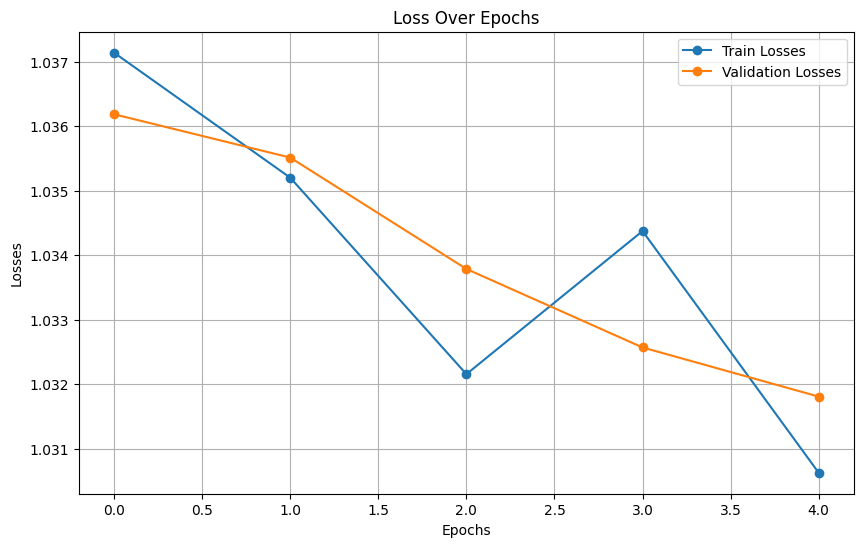

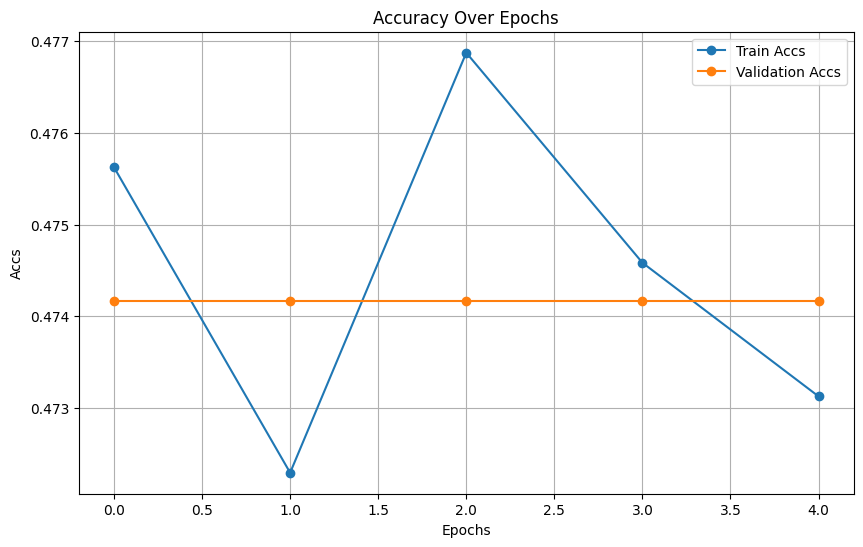

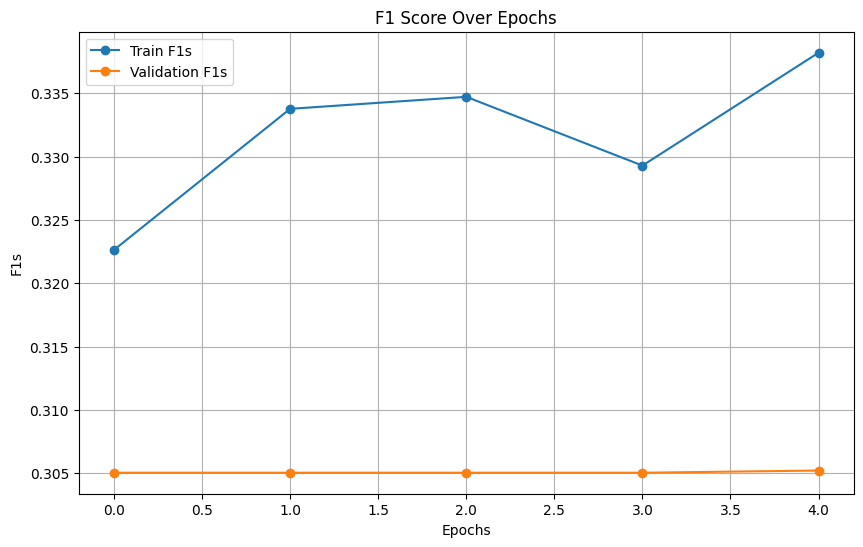

FileNotFoundError: Cannot find file: /content/loss_plot.png

In [ ]:
import gc
import torch
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Clear memory and reset GPU
gc.collect()
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"GPU memory available: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")

# Initialize optimizer and learning rate scheduler
optimizer = AdamW([p for p in model.parameters() if p.requires_grad], lr=2e-5, weight_decay=0.01)

# Define number of steps for scheduler
num_training_steps = len(train_loader) * num_epochs
num_warmup_steps = num_training_steps // 10

# Initialize scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=num_warmup_steps,
    num_training_steps=num_training_steps
)

# Mixed precision training scaler
scaler = torch.amp.GradScaler('cuda')

# Training loop
num_epochs = 5
best_val_f1 = 0
metrics = {
    'train_losses': [], 'val_losses': [],
    'train_accs': [], 'val_accs': [],
    'train_f1s': [], 'val_f1s': [],
    'train_precisions': [], 'val_precisions': [],
    'train_recalls': [], 'val_recalls': []
}

print("\n=== Starting Training ===")
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch + 1}/{num_epochs}")

    # Training phase
    model.train()
    train_loss = 0
    train_true_labels = []
    train_pred_labels = []

    for batch_idx, batch in enumerate(tqdm(train_loader, desc="Training")):
        inputs = {k: v.to(device) for k, v in batch.items()}

        with torch.amp.autocast('cuda'):
            outputs = model(**inputs)
            loss = outputs.loss / accumulation_steps
            logits = outputs.logits

        scaler.scale(loss).backward()
        if (batch_idx + 1) % accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            optimizer.zero_grad()

        train_loss += loss.item() * accumulation_steps
        predictions = torch.argmax(logits, dim=1)
        train_true_labels.extend(inputs['labels'].cpu().numpy())
        train_pred_labels.extend(predictions.cpu().numpy())

    # Calculate training metrics
    train_accuracy = accuracy_score(train_true_labels, train_pred_labels)
    train_f1 = f1_score(train_true_labels, train_pred_labels, average='weighted')
    train_precision = precision_score(train_true_labels, train_pred_labels, average='weighted')
    train_recall = recall_score(train_true_labels, train_pred_labels, average='weighted')

    # Validation phase
    model.eval()
    val_loss = 0
    val_true_labels = []
    val_pred_labels = []
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validation"):
            inputs = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**inputs)
            val_loss += outputs.loss.item()
            predictions = torch.argmax(outputs.logits, dim=1)
            val_true_labels.extend(inputs['labels'].cpu().numpy())
            val_pred_labels.extend(predictions.cpu().numpy())

    # Calculate validation metrics
    val_accuracy = accuracy_score(val_true_labels, val_pred_labels)
    val_precision = precision_score(val_true_labels, val_pred_labels, average='weighted')
    val_recall = recall_score(val_true_labels, val_pred_labels, average='weighted')
    val_f1 = f1_score(val_true_labels, val_pred_labels, average='weighted')

    # Update metrics
    metrics['train_losses'].append(train_loss / len(train_loader))
    metrics['val_losses'].append(val_loss / len(val_loader))
    metrics['train_accs'].append(train_accuracy)
    metrics['val_accs'].append(val_accuracy)
    metrics['train_f1s'].append(train_f1)
    metrics['val_f1s'].append(val_f1)
    metrics['train_precisions'].append(train_precision)
    metrics['val_precisions'].append(val_precision)
    metrics['train_recalls'].append(train_recall)
    metrics['val_recalls'].append(val_recall)

    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_f1': val_f1,
            'metrics': metrics
        }, 'best_model.pt')
        print(f"\nSaved new best model with F1 score: {val_f1:.4f}")

# Save final model
torch.save({
    'epoch': num_epochs,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scheduler_state_dict': scheduler.state_dict(),
    'metrics': metrics
}, 'final_model.pt')
print("\nFinal model saved as 'final_model.pt'")

# Download models

from google.colab import files
best_model_path = 'best_model.pt'
final_model_path = 'final_model.pt'
files.download(best_model_path)
files.download(final_model_path)



# Plot metrics
def plot_metrics(metrics, metric_name, title):
    plt.figure(figsize=(10, 6))
    plt.plot(metrics[f'train_{metric_name}'], label=f'Train {metric_name.capitalize()}', marker='o')
    plt.plot(metrics[f'val_{metric_name}'], label=f'Validation {metric_name.capitalize()}', marker='o')
    plt.title(f'{title} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(metric_name.capitalize())
    plt.legend()
    plt.grid(True)
    plt.show()

metrics_df = pd.DataFrame(metrics)
print("\n=== Metrics Table ===")
print(metrics_df)
metrics_csv_path = "/content/metrics_table.csv"
metrics_df.to_csv(metrics_csv_path, index=False)
files.download(metrics_csv_path)



plot_metrics(metrics, 'losses', 'Loss')
plot_metrics(metrics, 'accs', 'Accuracy')
plot_metrics(metrics, 'f1s', 'F1 Score')

# Download plots
files.download('/content/loss_plot.png')
files.download('/content/accuracy_plot.png')
files.download('/content/f1_plot.png')




# **prediction part**

GPU memory available: 15.84 GB

=== Loading Dataset ===
Downloading...
From (original): https://drive.google.com/uc?id=1euaUIL-xNVbhMLK-pqYH_cz75baO4ueC
From (redirected): https://drive.google.com/uc?id=1euaUIL-xNVbhMLK-pqYH_cz75baO4ueC&confirm=t&uuid=f5ec6cf5-7e54-438d-b7c4-c2519c8007a6
To: /content/unlabeled_data.csv
100% 451M/451M [00:02<00:00, 173MB/s]
Dataset size: 42367 rows

=== Loading Tokenizer ===

=== Loading Model ===


<ipython-input-36-087fc11a9117>:81: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path, map_location=device)
Some weights of BertForSequen

Model loaded successfully.

=== Predicting Labels ===


Predicting Labels:   2%|▏         | 101/5296 [00:20<18:10,  4.76it/s]

Saved 800 predictions so far.


Predicting Labels:   4%|▍         | 200/5296 [00:41<22:43,  3.74it/s]

Saved 1600 predictions so far.


Predicting Labels:   6%|▌         | 301/5296 [01:02<22:46,  3.66it/s]

Saved 2400 predictions so far.


Predicting Labels:   8%|▊         | 401/5296 [01:23<20:49,  3.92it/s]

Saved 3200 predictions so far.


Predicting Labels:   9%|▉         | 500/5296 [01:45<24:09,  3.31it/s]

Saved 4000 predictions so far.


Predicting Labels:  11%|█▏        | 600/5296 [02:07<30:34,  2.56it/s]

Saved 4800 predictions so far.


Predicting Labels:  13%|█▎        | 700/5296 [02:30<31:00,  2.47it/s]

Saved 5600 predictions so far.


Predicting Labels:  15%|█▌        | 801/5296 [02:52<22:41,  3.30it/s]

Saved 6400 predictions so far.


Predicting Labels:  17%|█▋        | 901/5296 [03:14<22:55,  3.19it/s]

Saved 7200 predictions so far.


Predicting Labels:  19%|█▉        | 1000/5296 [03:36<38:04,  1.88it/s]

Saved 8000 predictions so far.


Predicting Labels:  21%|██        | 1100/5296 [03:58<28:30,  2.45it/s]

Saved 8800 predictions so far.


Predicting Labels:  23%|██▎       | 1200/5296 [04:20<27:58,  2.44it/s]

Saved 9600 predictions so far.


Predicting Labels:  25%|██▍       | 1300/5296 [04:43<34:25,  1.94it/s]

Saved 10400 predictions so far.


Predicting Labels:  26%|██▋       | 1400/5296 [05:05<38:29,  1.69it/s]

Saved 11200 predictions so far.


Predicting Labels:  28%|██▊       | 1500/5296 [05:28<28:51,  2.19it/s]

Saved 12000 predictions so far.


Predicting Labels:  30%|███       | 1600/5296 [05:50<29:29,  2.09it/s]

Saved 12800 predictions so far.


Predicting Labels:  32%|███▏      | 1700/5296 [06:13<43:42,  1.37it/s]

Saved 13600 predictions so far.


Predicting Labels:  34%|███▍      | 1800/5296 [06:36<29:49,  1.95it/s]

Saved 14400 predictions so far.


Predicting Labels:  36%|███▌      | 1901/5296 [06:59<24:14,  2.33it/s]

Saved 15200 predictions so far.


Predicting Labels:  38%|███▊      | 2000/5296 [07:22<45:01,  1.22it/s]

Saved 16000 predictions so far.


Predicting Labels:  40%|███▉      | 2101/5296 [07:45<24:13,  2.20it/s]

Saved 16800 predictions so far.


Predicting Labels:  42%|████▏     | 2200/5296 [08:07<29:41,  1.74it/s]

Saved 17600 predictions so far.


Predicting Labels:  43%|████▎     | 2300/5296 [08:31<45:33,  1.10it/s]

Saved 18400 predictions so far.


Predicting Labels:  45%|████▌     | 2400/5296 [08:54<29:21,  1.64it/s]

Saved 19200 predictions so far.


Predicting Labels:  47%|████▋     | 2500/5296 [09:17<29:20,  1.59it/s]

Saved 20000 predictions so far.


Predicting Labels:  49%|████▉     | 2600/5296 [09:41<45:16,  1.01s/it]

Saved 20800 predictions so far.


Predicting Labels:  51%|█████     | 2700/5296 [10:04<29:09,  1.48it/s]

Saved 21600 predictions so far.


Predicting Labels:  53%|█████▎    | 2800/5296 [10:27<28:47,  1.44it/s]

Saved 22400 predictions so far.


Predicting Labels:  55%|█████▍    | 2900/5296 [10:52<44:10,  1.11s/it]

Saved 23200 predictions so far.


Predicting Labels:  57%|█████▋    | 3000/5296 [11:15<27:21,  1.40it/s]

Saved 24000 predictions so far.


Predicting Labels:  59%|█████▊    | 3100/5296 [11:38<26:27,  1.38it/s]

Saved 24800 predictions so far.


Predicting Labels:  60%|██████    | 3200/5296 [12:03<38:57,  1.12s/it]

Saved 25600 predictions so far.


Predicting Labels:  62%|██████▏   | 3300/5296 [12:26<24:50,  1.34it/s]

Saved 26400 predictions so far.


Predicting Labels:  64%|██████▍   | 3400/5296 [12:49<25:04,  1.26it/s]

Saved 27200 predictions so far.


Predicting Labels:  66%|██████▌   | 3500/5296 [13:14<31:13,  1.04s/it]

Saved 28000 predictions so far.


Predicting Labels:  68%|██████▊   | 3600/5296 [13:37<22:41,  1.25it/s]

Saved 28800 predictions so far.


Predicting Labels:  70%|██████▉   | 3700/5296 [14:03<34:44,  1.31s/it]

Saved 29600 predictions so far.


Predicting Labels:  72%|███████▏  | 3800/5296 [14:26<21:03,  1.18it/s]

Saved 30400 predictions so far.


Predicting Labels:  74%|███████▎  | 3900/5296 [14:50<19:54,  1.17it/s]

Saved 31200 predictions so far.


Predicting Labels:  76%|███████▌  | 4000/5296 [15:15<29:14,  1.35s/it]

Saved 32000 predictions so far.


Predicting Labels:  77%|███████▋  | 4100/5296 [15:39<17:37,  1.13it/s]

Saved 32800 predictions so far.


Predicting Labels:  79%|███████▉  | 4200/5296 [16:03<16:19,  1.12it/s]

Saved 33600 predictions so far.


Predicting Labels:  81%|████████  | 4300/5296 [16:28<20:38,  1.24s/it]

Saved 34400 predictions so far.


Predicting Labels:  83%|████████▎ | 4400/5296 [16:52<13:47,  1.08it/s]

Saved 35200 predictions so far.


Predicting Labels:  85%|████████▍ | 4500/5296 [17:18<20:05,  1.51s/it]

Saved 36000 predictions so far.


Predicting Labels:  87%|████████▋ | 4600/5296 [17:42<11:20,  1.02it/s]

Saved 36800 predictions so far.


Predicting Labels:  89%|████████▊ | 4700/5296 [18:07<12:42,  1.28s/it]

Saved 37600 predictions so far.


Predicting Labels:  91%|█████████ | 4800/5296 [18:32<10:02,  1.22s/it]

Saved 38400 predictions so far.


Predicting Labels:  93%|█████████▎| 4900/5296 [18:56<06:45,  1.02s/it]

Saved 39200 predictions so far.


Predicting Labels:  94%|█████████▍| 5000/5296 [19:23<08:07,  1.65s/it]

Saved 40000 predictions so far.


Predicting Labels:  96%|█████████▋| 5100/5296 [19:47<03:31,  1.08s/it]

Saved 40800 predictions so far.


Predicting Labels:  98%|█████████▊| 5200/5296 [20:13<02:15,  1.42s/it]

Saved 41600 predictions so far.


Predicting Labels: 100%|██████████| 5296/5296 [20:34<00:00,  4.29it/s]


Prediction completed and saved!

=== Sample Predictions ===
                                                post  \
0  i've become aware of a fascinating conspiracy ...   
1  edit: i have been convinced that renewables sh...   
2  looking at individual humans, its easy to see ...   
3  edit: i reworded the first paragraph of the po...   
4  first, i must disclaim im not an economist ; i...   

                                             comment  predicted_label  
0  answer: we're not allowed to say the real grou...                1  
1  the difference is outlined in this report page...                1  
2  what i'm more trying to express is that even i...                1  
3  if elon uncensors and unbans many accounts or ...                1  
4  20 years is a lot of time to expand your labor...                2  


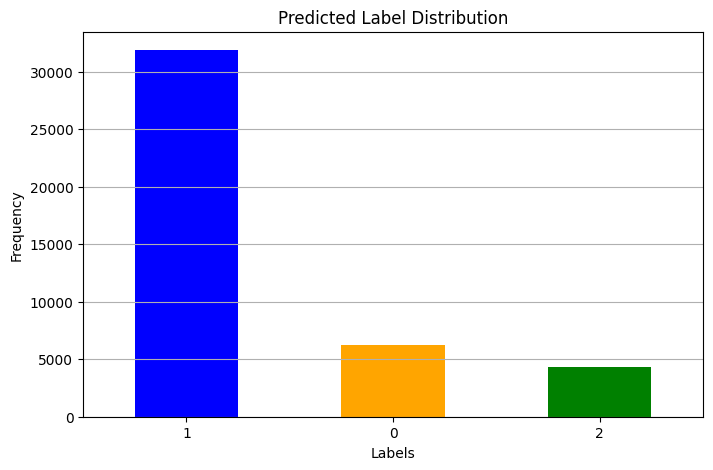


=== Label Distribution ===
predicted_label
1    31868
0     6202
2     4297
Name: count, dtype: int64


In [ ]:
import gc
import os
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
import pandas as pd
from tqdm import tqdm

# Clear memory and reset GPU
gc.collect()
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.reset_peak_memory_stats()
    print(f"GPU memory available: {torch.cuda.get_device_properties(0).total_memory/1e9:.2f} GB")

# Dataset class with truncation handling
class UnlabeledDataset(Dataset):
    def __init__(self, posts, comments, tokenizer, max_length=512):
        self.posts = posts
        self.comments = comments
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.posts)

    def __getitem__(self, idx):
        post = self.posts[idx]
        comment = self.comments[idx]

        # Truncate if necessary
        post = post[:self.max_length // 2]
        comment = comment[:self.max_length // 2]

        encoding = self.tokenizer(
            post,
            comment,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )
        return {key: val.squeeze(0) for key, val in encoding.items()}

# Load the dataset
print("\n=== Loading Dataset ===")
!gdown "https://drive.google.com/uc?id=1euaUIL-xNVbhMLK-pqYH_cz75baO4ueC"
data = pd.read_csv('unlabeled_data.csv')
print(f"Dataset size: {len(data)} rows")

# Check for NaN values
#print("\nChecking for NaN values:")
3#print(data.isnull().sum())

# Remove rows with NaN values
#data = data.dropna(subset=['cleaned_text', 'cleaned_body'])
#print(f"\nDataset size after removing NaN: {len(data)} rows")

# Prepare data
unlabeled_posts = data['cleaned_text'].tolist()
unlabeled_comments = data['cleaned_body'].tolist()

# Tokenizer initialization
print("\n=== Loading Tokenizer ===")
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Prepare the dataset and DataLoader
unlabeled_dataset = UnlabeledDataset(unlabeled_posts, unlabeled_comments, tokenizer)
unlabeled_loader = DataLoader(
    unlabeled_dataset,
    batch_size=8,  # Reduce batch size for large datasets
    shuffle=False,
    pin_memory=True,
    num_workers=2
)

# Load the model
print("\n=== Loading Model ===")
checkpoint_path = 'best_model.pt'
checkpoint = torch.load(checkpoint_path, map_location=device)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()
print("Model loaded successfully.")

# Initialize for intermediate saving
predicted_labels = []
start_index = 0

# Check if intermediate results exist
if os.path.exists('predicted_labels_intermediate.csv'):
    intermediate_df = pd.read_csv('predicted_labels_intermediate.csv')
    predicted_labels = intermediate_df['predicted_label'].tolist()
    start_index = len(predicted_labels)
    print(f"Resuming from {start_index} predictions...")

# Adjust DataLoader to skip completed items
unlabeled_dataset = UnlabeledDataset(unlabeled_posts[start_index:], unlabeled_comments[start_index:], tokenizer)
unlabeled_loader = DataLoader(unlabeled_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=2)

# Prediction loop with intermediate saves
print("\n=== Predicting Labels ===")
with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(unlabeled_loader, desc="Predicting Labels")):
        inputs = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=1)
        predicted_labels.extend(predictions.cpu().numpy())

        # Save intermediate results every 100 batches
        if (batch_idx + 1) % 100 == 0:
            intermediate_df = pd.DataFrame({
                'post': unlabeled_posts[:len(predicted_labels)],
                'comment': unlabeled_comments[:len(predicted_labels)],
                'predicted_label': predicted_labels
            })
            intermediate_df.to_csv('predicted_labels_intermediate.csv', index=False)
            print(f"Saved {len(predicted_labels)} predictions so far.")

# Save final results
predicted_df = pd.DataFrame({
    'post': unlabeled_posts,
    'comment': unlabeled_comments,
    'predicted_label': predicted_labels
})
predicted_df.to_csv('predicted_labels.csv', index=False)
print("Prediction completed and saved!")

# Analyze and plot results
print("\n=== Sample Predictions ===")
print(predicted_df.head())

# Plot label distribution
import matplotlib.pyplot as plt
label_counts = predicted_df['predicted_label'].value_counts()
plt.figure(figsize=(8, 5))
label_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.title('Predicted Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

print("\n=== Label Distribution ===")
print(label_counts)
